In [ ]:
!pip install pillow-heif

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import pillow_heif
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import  models, datasets, transforms
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Deep_Proj"
random.seed(42)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
train_dataset = datasets.ImageFolder(
    root="/content/drive/MyDrive/Deep_Proj/dataset_split/train",
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root="/content/drive/MyDrive/Deep_Proj/dataset_split/val",
    transform=val_transform
)

test_dataset = datasets.ImageFolder(
    root="/content/drive/MyDrive/Deep_Proj/dataset_split/test",
    transform=val_transform
)


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
class EncodingLayer(nn.Module):
    def  __init__(self, in_channels, num_codes=32, dropout = 0.5):
        super().__init__()
        self.in_channels = in_channels
        self.num_codes = num_codes

        self.codewords = nn.Parameter(torch.Tensor(num_codes, in_channels))
        self.log_scale = nn.Parameter(torch.Tensor(num_codes))

        nn.init.kaiming_uniform_(self.codewords, mode = "fan_out", nonlinearity="relu")
        nn.init.normal_(self.log_scale, 0.0, 0.1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        b, c, h, w = x.size()
        n = h * w
        x = x.permute(0, 2, 3, 1).contiguous().view(b, n, c)

        codewords = self.codewords.view(1, 1, self.num_codes, c)
        residuals = x.unsqueeze(2) - codewords

        dist2 = (residuals ** 2).sum(dim=3)
        s = F.softplus(self.log_scale) + 1e-6

        Assigningv = F.softmax(-dist2 * s.view(1, 1, self.num_codes), dim=2)
        encodingv = (Assigningv.unsqueeze(3) * residuals).sum(dim=1)

        flattened_e = encodingv.reshape(b, -1)

        e = F.normalize(flattened_e, p = 2, dim=1)
        return self.dropout(e)


In [ ]:
class HierarchicalCNN(nn.Module):
    def __init__(
        self,
        num_fine=5,
        num_coarse=2,
        pretrained=True,
        reduce_dim=128,
        num_codes=32,
        dropout=0.5
    ):
        super().__init__()
        baseline = models.mobilenet_v2(pretrained=pretrained)

        self.backbone = baseline.features
        self.backbone_out = 1280

        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.coarse_head = nn.Linear(self.backbone_out, num_coarse)

        self.reduce = nn.Sequential(
            nn.Conv2d(self.backbone_out, reduce_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(reduce_dim),
            nn.ReLU(inplace=True),
        )

        self.encoding = EncodingLayer(
            in_channels=reduce_dim,
            num_codes=num_codes,
            dropout=dropout
        )
        self.fine_head = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_codes * reduce_dim, num_fine)
        )


    def forward(self, x):
        fmap = self.backbone(x)
        coarse_features = self.gap(fmap).flatten(1)
        coarse_logits = self.coarse_head(coarse_features)

        reduced = self.reduce(fmap)
        encoded = self.encoding(reduced)
        fine_logits = self.fine_head(encoded)
        return fine_logits, coarse_logits


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
fine_to_coarse = torch.tensor([1, 0, 1, 0, 0], dtype=torch.long).to(device)

In [ ]:
model = HierarchicalCNN(
    num_fine=5,
    num_coarse=2,
    pretrained=True,
    reduce_dim=128,
    num_codes=32,
    dropout=0.3
).to(device)

criterion_fine = nn.CrossEntropyLoss()
criterion_coarse = nn.CrossEntropyLoss()
lambda_coarse = 0.3

backbone_params = list(model.backbone.parameters())
head_params = (
    list(model.coarse_head.parameters()) +
    list(model.reduce.parameters()) +
    list(model.encoding.parameters()) +
    list(model.fine_head.parameters())
)
optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': head_params, 'lr': 1e-4}
], weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=30,
    eta_min=1e-6
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 191MB/s]


In [ ]:
def run_train_Sepoch(
    model,
    loader,
    optimizer,
    criterion_fine,
    criterion_coarse,
    fine_to_coarse,
    lambda_coarse,
    device
):
    model.train()
    running_loss = 0.0

    fine_correct = 0
    fine_total = 0

    coarse_correct = 0
    coarse_total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        coarse_labels = fine_to_coarse[labels]

        optimizer.zero_grad()
        fine_logits, coarse_logits = model(images)

        loss_f = criterion_fine(fine_logits, labels)
        loss_c = criterion_coarse(coarse_logits, coarse_labels)
        loss = loss_f + lambda_coarse * loss_c

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        fine_preds = fine_logits.argmax(dim=1)
        fine_correct += (fine_preds == labels).sum().item()
        fine_total += labels.size(0)

        coarse_preds = coarse_logits.argmax(dim=1)
        coarse_correct += (coarse_preds == coarse_labels).sum().item()
        coarse_total += labels.size(0)


    avg_loss  = running_loss / len(loader)
    fine_accuracy  = fine_correct / fine_total
    coarse_accuracy  = coarse_correct / coarse_total
    return avg_loss, fine_accuracy, coarse_accuracy

In [ ]:
@torch.no_grad()
def run_eval_Sepoch(
    model,
    loader,
    criterion_fine,
    criterion_coarse,
    fine_to_coarse,
    lambda_coarse,
    device
):
    model.eval()
    running_loss = 0.0

    fine_correct = 0
    fine_total = 0

    coarse_correct = 0
    coarse_total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        coarse_labels = fine_to_coarse[labels]

        fine_logits, coarse_logits = model(images)

        loss_f = criterion_fine(fine_logits, labels)
        loss_c = criterion_coarse(coarse_logits, coarse_labels)
        loss = loss_f + lambda_coarse * loss_c

        running_loss += loss.item()

        fine_preds = fine_logits.argmax(dim=1)
        fine_correct += (fine_preds == labels).sum().item()
        fine_total += labels.size(0)

        coarse_preds = coarse_logits.argmax(dim=1)
        coarse_correct += (coarse_preds == coarse_labels).sum().item()
        coarse_total += labels.size(0)


    avg_loss  = running_loss / len(loader)
    fine_accuracy  = fine_correct / fine_total
    coarse_accuracy  = coarse_correct / coarse_total
    return avg_loss, fine_accuracy, coarse_accuracy

In [ ]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion_fine,
    criterion_coarse,
    fine_to_coarse,
    lambda_coarse,
    device,
    num_epochs = 15
):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_coarse_accuracy": [],
        "val_coarse_accuracy": [],
    }


    for epoch in range(num_epochs):
        current_lambda = max(0.1, lambda_coarse * (0.5 + 0.5 * np.cos(np.pi * epoch / num_epochs)))
        if epoch > 0 and epoch % 5 == 0:
            current_lambda *= 0.8
            print(f"Lambda reduced to {current_lambda:.4f}")

        tr_loss, tr_acc, tr_cacc = run_train_Sepoch(
            model, train_loader, optimizer,
            criterion_fine, criterion_coarse,
            fine_to_coarse, current_lambda, device
        )

        va_loss, va_acc, va_cacc = run_eval_Sepoch(
            model, val_loader,
            criterion_fine, criterion_coarse,
            fine_to_coarse, current_lambda, device
        )
        scheduler.step()

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_accuracy"].append(tr_acc)
        history["val_accuracy"].append(va_acc)
        history["train_coarse_accuracy"].append(tr_cacc)
        history["val_coarse_accuracy"].append(va_cacc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {tr_loss:.4f}, Val Loss: {va_loss:.4f}, "
            f"Train Accuracy: {tr_acc:.4f}, Val Accuracy: {va_acc:.4f}, "
            f"Train Coarse Accuracy: {tr_cacc:.4f}, Val Coarse Accuracy: {va_cacc:.4f},"
            f"LR: {optimizer.param_groups[0]['lr']:.2e},"
            f"Current Lambda: {current_lambda:.3f}"
        )

    return history

In [ ]:
def Test(
    model,
    test_loader,
    criterion_fine,
    criterion_coarse,
    fine_to_coarse,
    lambda_coarse,
    device
):
    model.eval()

    test_loss = 0.0
    fine_correct = 0
    fine_total = 0

    coarse_correct = 0
    coarse_total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            coarse_labels = fine_to_coarse[labels]

            fine_logits, coarse_logits = model(images)

            loss_f = criterion_fine(fine_logits, labels)
            loss_c = criterion_coarse(coarse_logits, coarse_labels)
            loss = loss_f + lambda_coarse * loss_c

            batch_size = labels.size(0)
            test_loss += loss.item() * batch_size

            fine_preds = fine_logits.argmax(dim=1)
            fine_correct += (fine_preds == labels).sum().item()
            fine_total += labels.size(0)

            coarse_preds = coarse_logits.argmax(dim=1)
            coarse_correct += (coarse_preds == coarse_labels).sum().item()
            coarse_total += labels.size(0)

            all_preds.extend(fine_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= fine_total
    test_acc = fine_correct / fine_total
    test_coarse_acc = coarse_correct / coarse_total

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy (Fine): {test_acc:.4f}")
    print(f"Test Accuracy (Coarse): {test_coarse_acc:.4f}")

    return all_labels, all_preds


In [ ]:
history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion_fine=criterion_fine,
    criterion_coarse=criterion_coarse,
    fine_to_coarse=fine_to_coarse,
    lambda_coarse=lambda_coarse,
    device=device,
    num_epochs=30
)


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (100742739 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98472915 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90418780 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch [1/30] Train Loss: 1.6963, Val Loss: 1.6034, Train Accuracy: 0.5945, Val Accuracy: 0.8500, Train Coarse Accuracy: 0.8573, Val Coarse Accuracy: 0.9361,LR: 9.98e-06,Current Lambda: 0.300


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (91411509 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96864328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch [2/30] Train Loss: 1.5738, Val Loss: 1.4921, Train Accuracy: 0.8115, Val Accuracy: 0.8806, Train Coarse Accuracy: 0.9263, Val Coarse Accuracy: 0.9472,LR: 9.90e-06,Current Lambda: 0.299


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [3/30] Train Loss: 1.4619, Val Loss: 1.3682, Train Accuracy: 0.8359, Val Accuracy: 0.8917, Train Coarse Accuracy: 0.9405, Val Coarse Accuracy: 0.9472,LR: 9.78e-06,Current Lambda: 0.297


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (102863580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch [4/30] Train Loss: 1.3462, Val Loss: 1.2413, Train Accuracy: 0.8526, Val Accuracy: 0.9028, Train Coarse Accuracy: 0.9459, Val Coarse Accuracy: 0.9472,LR: 9.61e-06,Current Lambda: 0.293


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (100898286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch [5/30] Train Loss: 1.2384, Val Loss: 1.1276, Train Accuracy: 0.8698, Val Accuracy: 0.9222, Train Coarse Accuracy: 0.9524, Val Coarse Accuracy: 0.9500,LR: 9.40e-06,Current Lambda: 0.287
Lambda reduced to 0.2239


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98216417 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96937635 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94333548 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch [6/30] Train Loss: 1.1191, Val Loss: 1.0194, Train Accuracy: 0.9043, Val Accuracy: 0.9278, Train Coarse Accuracy: 0.9566, Val Coarse Accuracy: 0.9528,LR: 9.14e-06,Current Lambda: 0.224


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98512722 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [7/30] Train Loss: 1.0440, Val Loss: 0.9390, Train Accuracy: 0.9168, Val Accuracy: 0.9417, Train Coarse Accuracy: 0.9542, Val Coarse Accuracy: 0.9528,LR: 8.84e-06,Current Lambda: 0.271


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94772701 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (105955872 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [8/30] Train Loss: 0.9713, Val Loss: 0.8747, Train Accuracy: 0.9239, Val Accuracy: 0.9417, Train Coarse Accuracy: 0.9572, Val Coarse Accuracy: 0.9583,LR: 8.51e-06,Current Lambda: 0.261


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93179703 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (91195137 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch [9/30] Train Loss: 0.9097, Val Loss: 0.8186, Train Accuracy: 0.9364, Val Accuracy: 0.9472, Train Coarse Accuracy: 0.9625, Val Coarse Accuracy: 0.9500,LR: 8.15e-06,Current Lambda: 0.250


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (91661531 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [10/30] Train Loss: 0.8475, Val Loss: 0.7582, Train Accuracy: 0.9394, Val Accuracy: 0.9500, Train Coarse Accuracy: 0.9590, Val Coarse Accuracy: 0.9611,LR: 7.75e-06,Current Lambda: 0.238
Lambda reduced to 0.1800


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (105786600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch [11/30] Train Loss: 0.7971, Val Loss: 0.7109, Train Accuracy: 0.9358, Val Accuracy: 0.9528, Train Coarse Accuracy: 0.9602, Val Coarse Accuracy: 0.9611,LR: 7.33e-06,Current Lambda: 0.180


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (100706150 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98466550 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [12/30] Train Loss: 0.7499, Val Loss: 0.6748, Train Accuracy: 0.9429, Val Accuracy: 0.9528, Train Coarse Accuracy: 0.9685, Val Coarse Accuracy: 0.9667,LR: 6.89e-06,Current Lambda: 0.211


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (97224134 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [13/30] Train Loss: 0.7133, Val Loss: 0.6415, Train Accuracy: 0.9507, Val Accuracy: 0.9611, Train Coarse Accuracy: 0.9596, Val Coarse Accuracy: 0.9611,LR: 6.44e-06,Current Lambda: 0.196


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (91512835 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99638172 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch [14/30] Train Loss: 0.6872, Val Loss: 0.6117, Train Accuracy: 0.9507, Val Accuracy: 0.9639, Train Coarse Accuracy: 0.9631, Val Coarse Accuracy: 0.9667,LR: 5.97e-06,Current Lambda: 0.181


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [15/30] Train Loss: 0.6523, Val Loss: 0.5850, Train Accuracy: 0.9542, Val Accuracy: 0.9639, Train Coarse Accuracy: 0.9691, Val Coarse Accuracy: 0.9667,LR: 5.50e-06,Current Lambda: 0.166
Lambda reduced to 0.1200


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [16/30] Train Loss: 0.6323, Val Loss: 0.5588, Train Accuracy: 0.9584, Val Accuracy: 0.9667, Train Coarse Accuracy: 0.9679, Val Coarse Accuracy: 0.9694,LR: 5.03e-06,Current Lambda: 0.120


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [17/30] Train Loss: 0.6111, Val Loss: 0.5441, Train Accuracy: 0.9512, Val Accuracy: 0.9667, Train Coarse Accuracy: 0.9631, Val Coarse Accuracy: 0.9694,LR: 4.56e-06,Current Lambda: 0.134


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101124000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch [18/30] Train Loss: 0.6136, Val Loss: 0.5261, Train Accuracy: 0.9411, Val Accuracy: 0.9667, Train Coarse Accuracy: 0.9596, Val Coarse Accuracy: 0.9667,LR: 4.11e-06,Current Lambda: 0.119


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99653520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93994555 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch [19/30] Train Loss: 0.5712, Val Loss: 0.5111, Train Accuracy: 0.9578, Val Accuracy: 0.9694, Train Coarse Accuracy: 0.9762, Val Coarse Accuracy: 0.9667,LR: 3.67e-06,Current Lambda: 0.104


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90060548 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [20/30] Train Loss: 0.5564, Val Loss: 0.5024, Train Accuracy: 0.9620, Val Accuracy: 0.9667, Train Coarse Accuracy: 0.9703, Val Coarse Accuracy: 0.9667,LR: 3.25e-06,Current Lambda: 0.100
Lambda reduced to 0.0800


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [21/30] Train Loss: 0.5458, Val Loss: 0.4964, Train Accuracy: 0.9596, Val Accuracy: 0.9667, Train Coarse Accuracy: 0.9703, Val Coarse Accuracy: 0.9611,LR: 2.85e-06,Current Lambda: 0.080


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93956613 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (95221398 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (95245560 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch [22/30] Train Loss: 0.5430, Val Loss: 0.4852, Train Accuracy: 0.9608, Val Accuracy: 0.9639, Train Coarse Accuracy: 0.9673, Val Coarse Accuracy: 0.9667,LR: 2.49e-06,Current Lambda: 0.100


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [23/30] Train Loss: 0.5558, Val Loss: 0.4825, Train Accuracy: 0.9459, Val Accuracy: 0.9667, Train Coarse Accuracy: 0.9620, Val Coarse Accuracy: 0.9667,LR: 2.16e-06,Current Lambda: 0.100


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94035733 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [24/30] Train Loss: 0.5118, Val Loss: 0.4768, Train Accuracy: 0.9667, Val Accuracy: 0.9694, Train Coarse Accuracy: 0.9744, Val Coarse Accuracy: 0.9667,LR: 1.86e-06,Current Lambda: 0.100


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90253596 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94203152 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch [25/30] Train Loss: 0.5329, Val Loss: 0.4739, Train Accuracy: 0.9578, Val Accuracy: 0.9694, Train Coarse Accuracy: 0.9673, Val Coarse Accuracy: 0.9694,LR: 1.60e-06,Current Lambda: 0.100
Lambda reduced to 0.0800


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (95849737 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94876544 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch [26/30] Train Loss: 0.5088, Val Loss: 0.4688, Train Accuracy: 0.9685, Val Accuracy: 0.9694, Train Coarse Accuracy: 0.9768, Val Coarse Accuracy: 0.9667,LR: 1.39e-06,Current Lambda: 0.080


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (102020612 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99299550 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93166659 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch [27/30] Train Loss: 0.5204, Val Loss: 0.4662, Train Accuracy: 0.9637, Val Accuracy: 0.9722, Train Coarse Accuracy: 0.9715, Val Coarse Accuracy: 0.9667,LR: 1.22e-06,Current Lambda: 0.100


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96478452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [28/30] Train Loss: 0.5244, Val Loss: 0.4650, Train Accuracy: 0.9554, Val Accuracy: 0.9750, Train Coarse Accuracy: 0.9625, Val Coarse Accuracy: 0.9667,LR: 1.10e-06,Current Lambda: 0.100


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92647926 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch [29/30] Train Loss: 0.5219, Val Loss: 0.4650, Train Accuracy: 0.9590, Val Accuracy: 0.9694, Train Coarse Accuracy: 0.9744, Val Coarse Accuracy: 0.9667,LR: 1.02e-06,Current Lambda: 0.100


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [30/30] Train Loss: 0.5130, Val Loss: 0.4637, Train Accuracy: 0.9673, Val Accuracy: 0.9750, Train Coarse Accuracy: 0.9715, Val Coarse Accuracy: 0.9667,LR: 1.00e-06,Current Lambda: 0.100


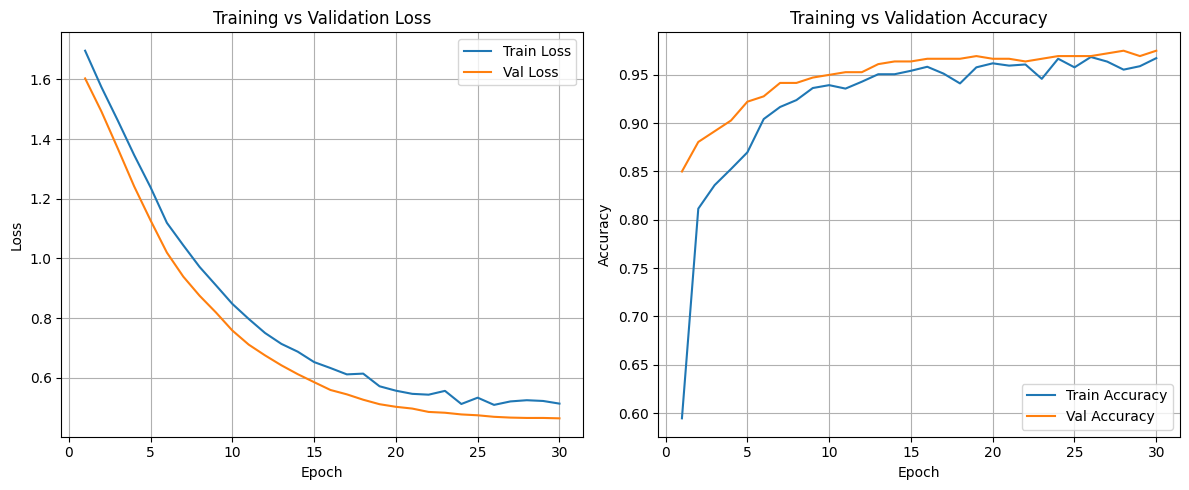

In [ ]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# ---- Loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# ---- Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_accuracy"], label="Train Accuracy")
plt.plot(epochs, history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


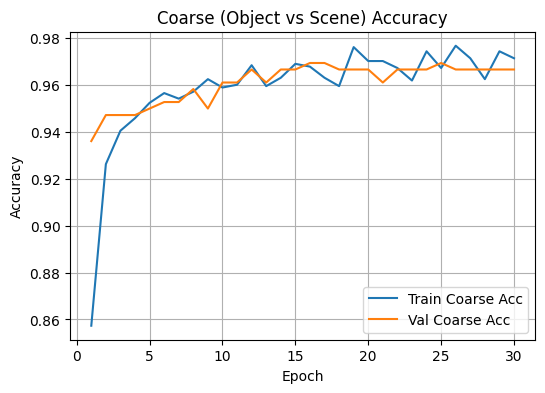

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_coarse_accuracy"], label="Train Coarse Acc")
plt.plot(epochs, history["val_coarse_accuracy"], label="Val Coarse Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Coarse (Object vs Scene) Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_true, y_pred = Test(
    model=model,
    test_loader=test_loader,
    criterion_fine=criterion_fine,
    criterion_coarse=criterion_coarse,
    fine_to_coarse=fine_to_coarse,
    lambda_coarse=lambda_coarse,
    device=device
)


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Loss: 0.4682
Test Accuracy (Fine): 0.9807
Test Accuracy (Coarse): 0.9835


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        fine_logits, _ = model(images)
        preds = fine_logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


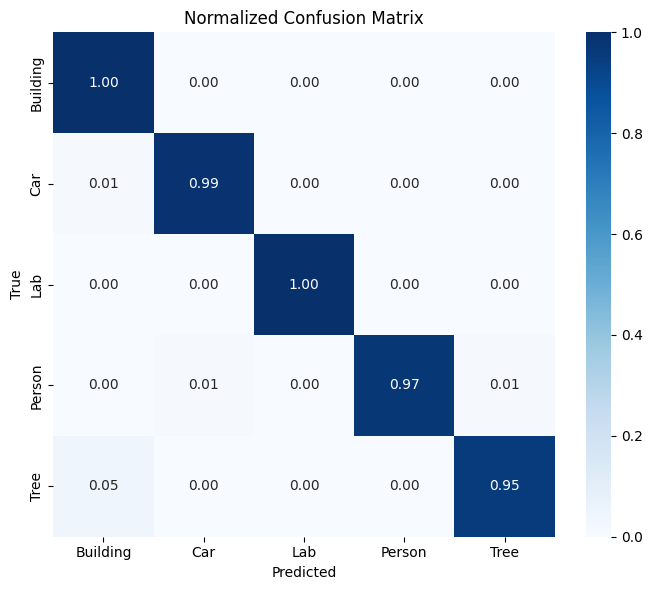

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=test_dataset.classes,
    yticklabels=test_dataset.classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()
